# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import math
%matplotlib inline

## Camera Calibration using chessboard images

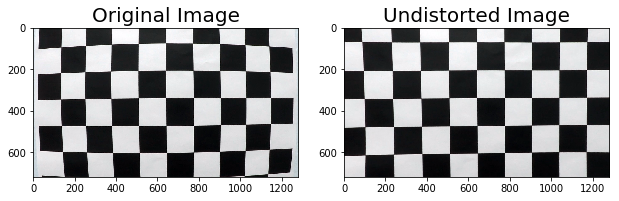

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

#Find parameters to undistort the image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#Test the matrix on one of the images
img = cv2.imread('./camera_cal/calibration1.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
#cv2.destroyAllWindows()

## Perspective transform Matrix

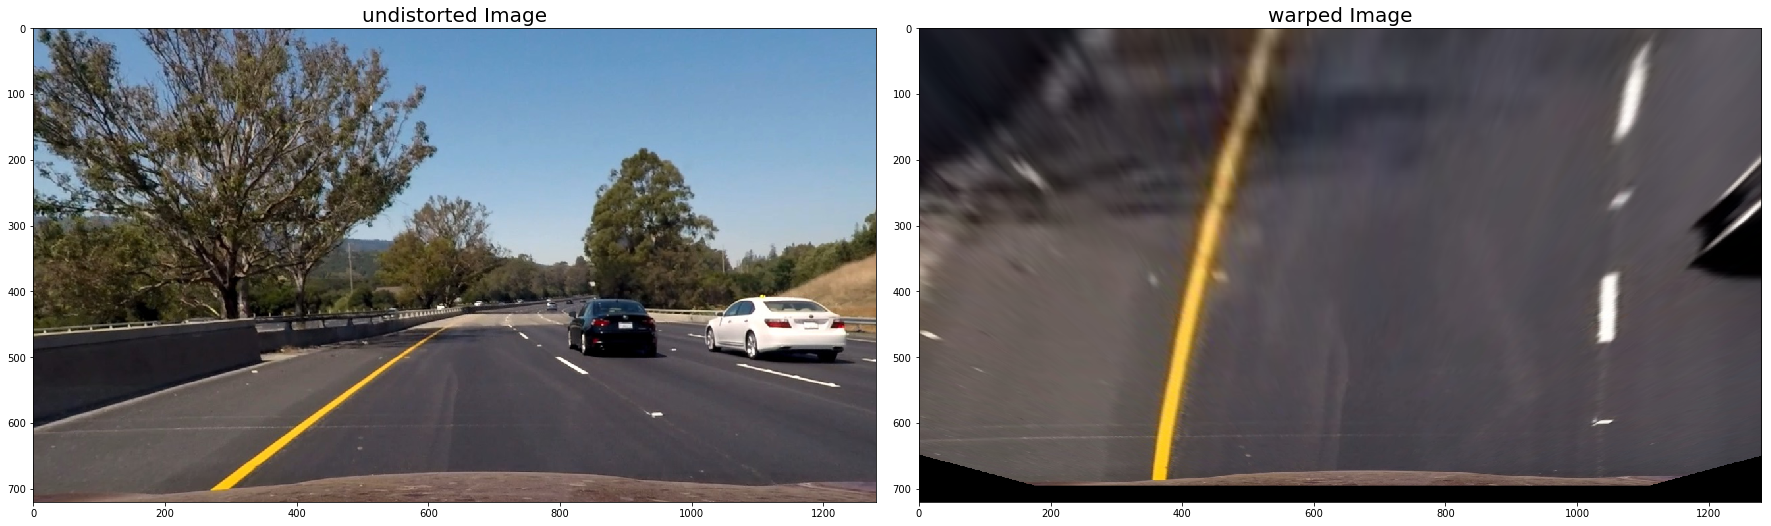

In [3]:
image = mpimg.imread('test_images/test6.jpg')
undistorted = cv2.undistort(image, mtx, dist, None, mtx)
y_max = 670
y_min = 460

x_l_b = 270
x_r_b = 1050
x_r_t = 714 
x_l_t = 572 

#Calculate Perspective Transformation Matrix
src = np.float32([[(x_l_b,y_max),(x_r_b,y_max), (x_r_t, y_min),(x_l_t,y_min)]])
dst = np.float32([[(x_l_b+50,y_max),(x_r_b-50,y_max), (x_r_b-50, 1),(x_l_b+50,1)]])
M = cv2.getPerspectiveTransform(src, dst)
#Inverse transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undistorted, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('undistorted Image', fontsize=20)
ax2.imshow(warped)
ax2.set_title('warped Image', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Ideas for Lane Detection Pipeline

- Calibrate the image
- Find Undistorted Images
- Gradient Thresholding with Color and Edges
- Perspective Transform 
- Lane detection using Histograms or Convolution
- Curve Fitting 
- Displaying the final results

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
#Write some fnctions

def get_undistorted_img(img):
    """
    Returns an undistorted image with the parameters calculated in camera calibration using chessboard cell.
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

def get_thresholded_img(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """
    Returns a thresholded image with combination of solbelx in lspace and Saturation of HLS color space
    try combining different approaches
    """
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary
    
    
def get_perspective_transformed_image(img):
    """
    Returns an undistorted image using perspective transform matrix.
    """
    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)



## Helper functions to find the lines

In [40]:
def find_initial_fit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    #Initially set it to value - add the 
    y_eval = np.max(ploty)
    
    #Radius of curvature in world frame
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature = (left_curverad+right_curverad)/2
    
    #distance to center
    #interceptions on left and right lane at bottom of image at y = 720
    left_intcpt =  left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_intcpt = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    # if car_pstn < 0, is it on left of center and >0 then it is on right of center
    car_pstn = ((left_intcpt+right_intcpt)/2 ) - 640
    #convert to meters
    car_pstn = car_pstn*xm_per_pix
    
    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty,curvature, car_pstn

   


In [41]:
def find_next_fit(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #### Visualization
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    """
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    """
    y_eval = np.max(ploty)
    #Radius of curvature in world frame
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature = (left_curverad+right_curverad)/2
    
    #distance to center
    #interceptions on left and right lane at bottom of image at y = 720
    left_intcpt =  left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_intcpt = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    # if car_pstn < 0, is it on left of center and >0 then it is on right of center
    car_pstn = ((left_intcpt+right_intcpt)/2 ) - 640
    #convert to meters
    car_pstn = car_pstn*xm_per_pix
    
    
    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, curvature, car_pstn
    

In [48]:
def get_final_image(warped,undist, left_fitx,right_fitx, ploty, curvature, car_pstn):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'radius of curvature = {}m'.format(int(curvature)),(180,150), font, 2,(255,0,0),3)
    if car_pstn < 0:
        cv2.putText(result,'car is {:.2f}m left of center'.format(-1 * car_pstn),(180,220), font, 2,(255,0,0),3)
    else:
        cv2.putText(result,'car is {:.2f}m right of center'.format(car_pstn),(180,250), font, 2,(255,0,0),3)
    
    return result
    #plt.imshow(result)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [9]:
import os
os.listdir("test_images/")

['test3.jpg',
 'test2.jpg',
 'test4.jpg',
 'test5.jpg',
 'straight_lines2.jpg',
 'test6.jpg',
 'test1.jpg',
 'straight_lines1.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

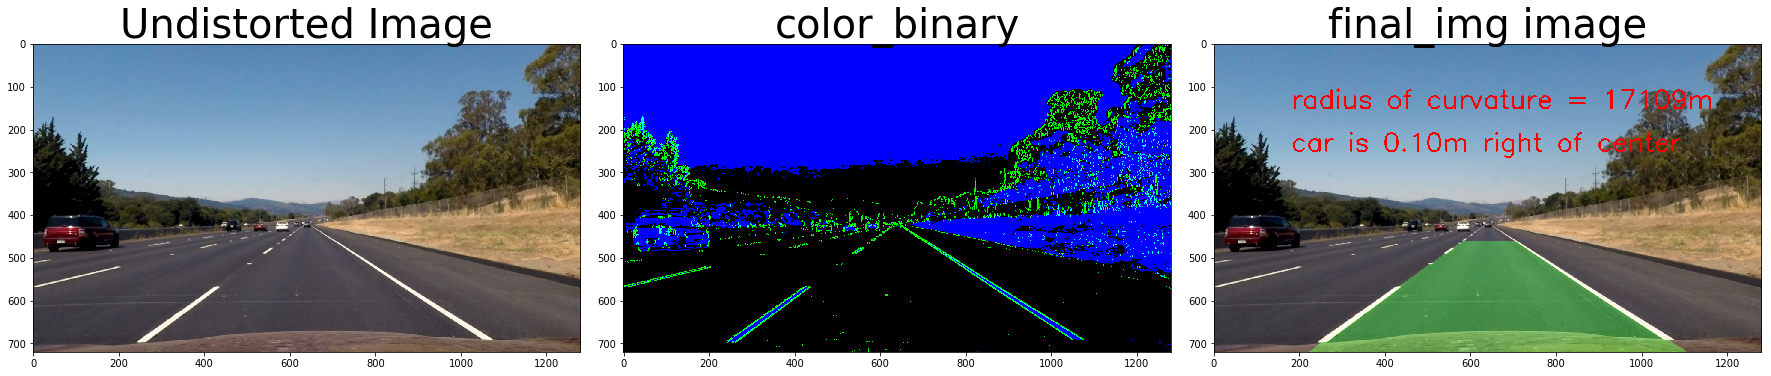

In [49]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.


# Read in an image from test images
image = mpimg.imread('test_images/straight_lines2.jpg')
#image = mpimg.imread('test_images/test6.jpg')
undis = get_undistorted_img(image)
color_binary, binary = get_thresholded_img(undis, s_thresh=(80, 255), sx_thresh=(20, 140))
warped = get_perspective_transformed_image(binary)

#out_img,left_fitx, right_fitx, ploty,  left_fit, right_fit = find_initial_fit(warped)
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, curvature, car_pstn = find_initial_fit(warped)

out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, curvature, car_pstn = find_next_fit(warped, left_fit, right_fit)

final_img = get_final_image(warped,undis, left_fitx,right_fitx, ploty, curvature, car_pstn)

#plt.imshow(binary_img)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undis)
ax1.set_title('Undistorted Image', fontsize=40)

ax2.imshow(color_binary)
ax2.set_title('color_binary', fontsize=40)
ax3.imshow(final_img)
ax3.set_title('final_img image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
first_image = True
left_fit = None
right_fit = None

### Pipeline to process the images from video

In [50]:
def process_image(image):
    global left_fit, right_fit, first_image
    undis = get_undistorted_img(image)
    color_binary, binary = get_thresholded_img(undis, s_thresh=(80, 255), sx_thresh=(20, 140))
    warped = get_perspective_transformed_image(binary)
    #out_img,left_fitx, right_fitx, ploty,  left_fit, right_fit = find_initial_fit(warped)
    if first_image == True:
        out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, curvature, car_pstn = find_initial_fit(warped)
        first_image = False
    else:
        out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, curvature, car_pstn = find_next_fit(warped, left_fit, right_fit)
        
    final_img = get_final_image(warped,undis, left_fitx,right_fitx, ploty, curvature, car_pstn)
    return final_img

Let's try the one with the solid white lane on the right first ...

In [51]:

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

white_output = 'out_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|█████████▉| 1260/1261 [03:30<00:00,  6.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

CPU times: user 7min 6s, sys: 25.4 s, total: 7min 32s
Wall time: 3min 31s


In [23]:
#Challenge Video Clip
white_output = 'out_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video out_challenge_video.mp4
[MoviePy] Writing video out_challenge_video.mp4


100%|██████████| 485/485 [01:11<00:00,  6.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_challenge_video.mp4 

CPU times: user 2min 37s, sys: 8.81 s, total: 2min 46s
Wall time: 1min 12s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

Now for the one with the solid yellow lane on the left. This one's more tricky!